# Multimodal Agentic RAG using Nomic Vision, FAISS, and LangGraph

## Overview

This project implements a **production-ready multimodal Agentic Retrieval-Augmented Generation (RAG) system** capable of answering questions grounded in **text, tables, and images extracted from PDFs**.

The system uses:

- Multimodal embeddings (`nomic-ai/nomic-embed-vision-v1`)
- Persistent vector storage (FAISS)
- Multimodal retrieval
- Agentic reasoning using LangGraph
- Grounded answer generation with source attribution

This architecture enables accurate, scalable, and low-latency question answering over multimodal documents.

---

## Architecture
Offline Pipeline:

PDF → Extract → Embed → Save FAISS index + metadata

Online Pipeline:

User Query → Agent → Retrieve → Multimodal LLM → Answer + Sources


---

## Key Features

- Multimodal support:
  - Text
  - Tables
  - Images
  - Page images

- Fully local embeddings (no API required)

- Persistent vector storage (fast retrieval)

- Agentic workflow using LangGraph

- Multimodal reranking using embedding similarity

- Grounded answers with source citations

- Optimized for Apple Silicon (Mac M2/M3)

---



In [14]:
import boto3
import tabula
import faiss
import json
import base64
import pymupdf
import requests
import os
import logging
import numpy as np
import warnings
from tqdm import tqdm
from botocore.exceptions import ClientError
from langchain_text_splitters import RecursiveCharacterTextSplitter
from IPython import display
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
import gc
import torch

from config import Config

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

/Users/manishraul/Documents/My_Data_Science_stuff/Adobe_assignment/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:25: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [15]:
import os
import json


# Create the directories
def create_directories(base_dir):
    directories = ["images", "text", "tables", "page_images"]
    for dir in directories:
        os.makedirs(os.path.join(base_dir, dir), exist_ok=True)

def save_items(items, base_dir, pdf_name, page_num):
    """
    Save extracted metadata (items) for each page to disk.
    Prevents memory accumulation and kernel crashes.
    """

    # remove .pdf extension
    pdf_name = os.path.splitext(pdf_name)[0]

    # create metadata folder
    metadata_dir = os.path.join(base_dir, "metadata", pdf_name)
    os.makedirs(metadata_dir, exist_ok=True)

    # metadata file per page
    output_file = os.path.join(
        metadata_dir,
        f"page_{page_num:04d}.json"
    )

    # save JSON
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(items, f, indent=2, ensure_ascii=False)

In [16]:
def process_images(filepath, doc, page, page_num, base_dir, items):

    images = page.get_images()

    for idx, image in enumerate(images):

        xref = image[0]

        pix = None
        pix_rgb = None

        try:
            pix = pymupdf.Pixmap(doc, xref)

            if pix.colorspace != pymupdf.csRGB:
                pix_rgb = pymupdf.Pixmap(pymupdf.csRGB, pix)
                pix = pix_rgb

            image_name = f"{base_dir}/images/{os.path.basename(filepath)}_image_{page_num}_{idx}_{xref}.png"

            pix.save(image_name)

            # DO NOT STORE BASE64
            items.append({
                "page": page_num,
                "type": "image",
                "path": image_name
            })

        except Exception as e:
            print(f"Image error: {e}")

        finally:
            if pix:
                pix = None
            if pix_rgb:
                pix_rgb = None

            del pix
            del pix_rgb
            gc.collect()

In [17]:
def process_page_images(page, page_num, base_dir, items):

    pix = None

    try:

        pix = page.get_pixmap(
            matrix=pymupdf.Matrix(150/72, 150/72)  # reduce resolution
        )

        page_path = os.path.join(
            base_dir,
            f"page_images/page_{page_num:03d}.png"
        )

        pix.save(page_path)

        # DO NOT STORE BASE64
        items.append({
            "page": page_num,
            "type": "page",
            "path": page_path
        })

    finally:

        if pix:
            pix = None

        del pix
        gc.collect()

In [18]:
def process_text_chunks(filepath, text, text_splitter, page_num, base_dir, items):

    chunks = text_splitter.split_text(text)

    for i, chunk in enumerate(chunks):

        text_file_name = f"{base_dir}/text/{os.path.basename(filepath)}_text_{page_num}_{i}.txt"

        with open(text_file_name, 'w') as f:
            f.write(chunk)

        # optional: don't store full text in memory
        items.append({
            "page": page_num,
            "type": "text",
            "text": chunk,
            "path": text_file_name
        })

    del chunks

In [19]:
def process_tables(filepath, page_num, base_dir, items):

    try:

        tables = tabula.read_pdf(
            filepath,
            pages=page_num + 1,
            multiple_tables=True
        )

        if not tables:
            return

        for table_idx, table in enumerate(tables):

            table_text = "\n".join(
                [" | ".join(map(str, row)) for row in table.values]
            )

            table_file_name = f"{base_dir}/tables/{os.path.basename(filepath)}_table_{page_num}_{table_idx}.txt"

            with open(table_file_name, 'w') as f:
                f.write(table_text)

            items.append({
                "page": page_num,
                "type": "table",
                "text": table_text,
                "path": table_file_name
            })

        del tables

    except Exception as e:
        print(f"Error extracting tables: {e}")

    gc.collect()

In [20]:
import os
import shutil

def clean_folder(folder_path):
    """
    Deletes the folder completely and recreates it empty.
    Safe and recommended for pipelines.
    """

    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")

    os.makedirs(folder_path, exist_ok=True)
    print(f"Created empty folder: {folder_path}")

In [ ]:

base_dir = "extracted_data"
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=200, length_function=len)

clean_folder(base_dir)
create_directories(base_dir)

for pdf in os.listdir("data"):
    if not pdf.lower().endswith(".pdf"):
        continue
    filepath = os.path.join("data", pdf)

    doc = pymupdf.open(filepath)

    try:

        for page_num in range(len(doc)):

            page = doc[page_num]

            items = []   # MUST reset per page

            text = page.get_text()


            process_tables(filepath, page_num, base_dir, items)

            process_text_chunks(
                filepath,
                text,
                text_splitter,
                page_num,
                base_dir,
                items
            )

            process_images(
                filepath,
                doc,
                page,
                page_num,
                base_dir,
                items
            )

            process_page_images(
                page,
                page_num,
                base_dir,
                items
            )

            # save metadata
            save_items(items, base_dir, pdf, page_num)

            # clear memory
            del items
            del text
            del page

            gc.collect()

    finally:
        doc.close()
        del doc
        gc.collect()

In [6]:
import os
import json

def load_all_items(base_dir):
    all_items = []

    metadata_dir = os.path.join(base_dir, "metadata")

    for pdf_name in os.listdir(metadata_dir):

        pdf_dir = os.path.join(metadata_dir, pdf_name)

        for file in sorted(os.listdir(pdf_dir)):

            if file.endswith(".json"):

                filepath = os.path.join(pdf_dir, file)

                with open(filepath, "r") as f:
                    page_items = json.load(f)

                    all_items.extend(page_items)

    return all_items

In [7]:
base_dir = "extracted_data"

items = load_all_items(base_dir)

print(f"Loaded {len(items)} items")

Loaded 3659 items


In [8]:
type(items[0]), items[100]

(dict,
 {'page': 8,
  'type': 'text',
  'text': '15\nCertain Relationships and Related Persons \nTransactions\n16\nCorporate Governance Guidelines & Codes of \nBusiness Conduct and Ethics\n16\nBoard Evaluation\n17\nCommunications with the Board\n17\nOur Directors\n18\nAttributes of Director Nominees\n19\nConsiderations in Evaluating Director Nominees\n20\nDirector Nominees\n21\nDirector Compensation for Fiscal Year 2024\n27\nExecutive Compensation\n30\nCompensation Discussion and Analysis\n31\nHighlights of Executive Compensation \nPrograms\n31\nCompensation Philosophy and Objectives\n34\nFiscal Year 2024 Compensation Programs \nDesign\n35\nFiscal Year 2024 Compensation Decisions and \nResults\n43\nOther Benefits, Programs and Policies\n49',
  'path': 'extracted_data/text/adbe-2025-proxy-statemnt.pdf_text_8_1.txt'})

In [9]:
# Looking at the first text item
[i for i in items if i['type'] == 'text'][100]

{'page': 14,
 'type': 'text',
 'text': 'directors” within the meaning of Rule 16b-3 under the \nSecurities Exchange Act of 1934 (the “Exchange Act”).\nû\nWe do not pay dividends on stock options, stock \nappreciation rights or unvested stock awards.\nü\nWe have clawback policies for performance-based \nincentive compensation and time-based equity \ncompensation of our executive officers.\nü\nWe have robust stock ownership requirements for our \ndirectors and officers at the senior vice president level \nand above.\nWhat we do\nWhat we don’t do\nCEO and All Other NEOs’ Target Pay Mix for Fiscal Year 2024(1)\n________________________\n(1)',
 'path': 'extracted_data/text/adbe-2025-proxy-statemnt.pdf_text_14_3.txt'}

In [10]:
# Looking at the first table item
[i for i in items if i['type'] == 'table'][0]

{'page': 6,
 'type': 'table',
 'text': '2.Approve the 2019 Equity Incentive Plan, as amended, to increase the available share\rreserve by 7 million shares.FOR\n3.Ratify the appointment of KPMG LLP as our independent registered public accounting\rfirm for our fiscal year ending on November 28, 2025.FOR\n4.\rApprove, on an advisory basis, the compensation of our named executive officers.FOR\n5.Vote on one stockholder proposal, if properly presented at the 2025 annual meeting of\rstockholders (the “2025 Annual Meeting”).AGAINST',
 'path': 'extracted_data/tables/adbe-2025-proxy-statemnt.pdf_table_6_0.txt'}

In [11]:
# Looking at the first image item
[i for i in items if i['type'] == 'image'][0]

{'page': 0,
 'type': 'image',
 'path': 'extracted_data/images/adbe-2025-stockholder-letter.pdf_image_0_0_52.png'}

In [ ]:
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModel

MODEL_ID = "nomic-ai/nomic-embed-vision-v1"

processor = AutoProcessor.from_pretrained(MODEL_ID)

model = AutoModel.from_pretrained(
    MODEL_ID,
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = model.to(device)
model.eval()

embedding_vector_dimension = model.config.n_embd

print("Embedding dimension:", embedding_vector_dimension)

In [ ]:
def generate_multimodal_embeddings(prompt=None, image_path=None):

    with torch.no_grad():

        if prompt is not None:

            dummy_image = Image.new("RGB", (224, 224), color=(255, 255, 255))

            inputs = processor(
                text=[prompt],
                images=[dummy_image],
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(device)

        elif image_path is not None:

            image = Image.open(image_path).convert("RGB")

            inputs = processor(
                text=[""],  # dummy text
                images=[image],
                return_tensors="pt"
            ).to(device)

        else:
            raise ValueError("Provide prompt or image_path")

        outputs = model(**inputs)

        # CLS token embedding
        embedding = outputs.last_hidden_state[:, 0, :]

        embedding = embedding.cpu().numpy()[0]

        # normalize for cosine similarity
        embedding = embedding / np.linalg.norm(embedding)

        return embedding.astype(np.float32)

In [ ]:
from tqdm import tqdm

# Set embedding vector dimension
embedding_vector_dimension = embedding_vector_dimension

# Count the number of each type of item
item_counts = {
    'text': sum(1 for item in items if item['type'] == 'text'),
    'table': sum(1 for item in items if item['type'] == 'table'),
    'image': sum(1 for item in items if item['type'] == 'image'),
    'page': sum(1 for item in items if item['type'] == 'page')
}

# Initialize counters
counters = dict.fromkeys(item_counts.keys(), 0)

# Generate embeddings for all items
with tqdm(
    total=len(items),
    desc="Generating embeddings",
    bar_format=(
        "{l_bar}{bar}| {n_fmt}/{total_fmt} "
        "[{elapsed}<{remaining}, {rate_fmt}{postfix}]"
    )
) as pbar:
    
    for item in items:
        item_type = item['type']
        page = item['page']
        path = item.get('path', 'N/A')
        counters[item_type] += 1
       
        ## updated part - start : pass file path instead of base64 to save memory
        try:

            if item_type in ['text', 'table']:

                if item.get("text"):
                    item['embedding'] = generate_multimodal_embeddings(
                        prompt=item['text']
                    )

            else:

                if os.path.exists(item.get("path", "")):
                    item['embedding'] = generate_multimodal_embeddings(
                        image_path=item['path']
                    )

        except Exception as e:

            print(f"Error at item {page}, at {path}: {e}")
        ## updated part - end
        
        # Update the progress bar
        pbar.set_postfix_str(f"Text: {counters['text']}/{item_counts['text']}, Table: {counters['table']}/{item_counts['table']}, Image: {counters['image']}/{item_counts['image']}")
        pbar.update(1)

In [ ]:
llm =  Config.get_llm()


# Generating RAG response with Amazon Nova
def invoke_nova_multimodal(prompt, matched_items):
    """
    Invoke the Amazon Nova model.
    """


    # Define your system prompt(s).
    system_msg = [
                        { "text": """You are a helpful assistant for question answering. 
                                    The text context is relevant information retrieved. 
                                    The provided image(s) are relevant information retrieved."""}
                 ]

    # Define one or more messages using the "user" and "assistant" roles.
    message_content = []

    for item in matched_items:
        if item['type'] == 'text' or item['type'] == 'table':
            message_content.append({"text": item['text']})
        else:
            message_content.append({"image": {
                                                "format": "png",
                                                "source": {"bytes": item['image']},
                                            }
                                    })


    # Configure the inference parameters.
    inf_params = {"max_new_tokens": 300, 
                "top_p": 0.9, 
                "top_k": 20}

    # Define the final message list
    message_list = [
        {"role": "user", "content": message_content}
    ]
    
    # Adding the prompt to the message list
    message_list.append({"role": "user", "content": [{"text": prompt}]})

    native_request = {
        "messages": message_list,
        "system": system_msg,
        "inferenceConfig": inf_params,
    }

    # Initialize the Amazon Bedrock runtime client
    # model_id = "llama3-70b-8192"
    # client = ChatGroq(model=Config.LLM_MODEL)

    # Invoke the model and extract the response body.
    response = llm.invoke(json.dumps(native_request))
    model_response = response.content
    
    return model_response

In [42]:
# User Query
query = "Which departments of adobe are underperforming in 2024 as per annual report?"

# Generate embeddings for the query
query_embedding = generate_multimodal_embeddings(prompt=query)

# query_embedding = generate_multimodal_embeddings(prompt=query)

# Search for the nearest neighbors in the vector database
distances, result = index.search(np.array(query_embedding, dtype=np.float32).reshape(1,-1), k=5)

Unused or unrecognized kwargs: text, padding, truncation.


In [46]:
distances

array([[1.0000001, 1.0000001, 1.0000001, 1.0000001, 1.0000001]],
      dtype=float32)

In [45]:
# Check the result (matched chunks)
result.flatten()

array([4, 3, 2, 1, 0])

In [44]:
# Retrieve the matched items
matched_items = [{k: v for k, v in items[index].items() if k != 'embedding'} for index in result.flatten()]

# Generate RAG response with Amazon Nova
response = invoke_nova_multimodal(query, matched_items)

display.Markdown(response)

Based on the provided annual report of Adobe, there is no mention of any department specifically being underperforming in 2024. However, since the revenue growth rates for both Digital Media and Digital Experience businesses are different, we can infer that one of them might be performing better than the other.

The Digital Media business grew 12% year-over-year, while the Digital Experience business grew 11% year-over-year. This slight difference in growth rates might indicate that the Digital Media business is performing better than the Digital Experience business in 2024.

However, without further information, it's difficult to make a definitive conclusion about which department is underperforming. The annual report does not provide a detailed breakdown of the performance of individual departments within Adobe.

To provide a more accurate answer, I would recommend checking other sources of information, such as quarterly earnings reports, investor presentations, or analyst research reports, which might provide more detailed insights into the performance of different departments within Adobe.

In [ ]:
#### List of questions -

# Financial Performance (Numerical Accuracy)
"What was Adobe's total revenue for Fiscal Year 2024?",
"How does the Q4 2024 revenue compare to Q4 2023?",
"What were the GAAP vs. Non-GAAP operating margins reported in the update?",
"Which business segment—Digital Media or Digital Experience—showed higher year-over-year growth?",
"What is Adobe's revenue guidance for the full year 2025?",

# AI & Strategy (Semantic Understanding)
"How is Adobe integrating generative AI across its Creative Cloud suite?",
"What are the primary use cases mentioned for Adobe Firefly in the enterprise sector?",
"What does the report cite as Adobe's primary competitive advantage in the AI era?",
"How is Adobe planning to monetize its new AI-driven features (e.g., 'Generative Credits')?",
"Mention any key strategic partnerships highlighted in the 2024 update.",

# Multimodal / Image-Based (Testing CLIP & Vision)
"Based on the 'Digital Media ARR' chart, what was the ending ARR for 2024?",
"Look at the slide showing the 'Content Supply Chain.' What are the four main stages of the workflow?",
"According to the Acrobat AI Assistant slide, what percentage increase in productivity was noted?",
"Which external partner logos appear on the 'Ecosystem' slide?",

# Complex Reasoning (Multi-Step Retrieval)
"Summarize the three biggest risks Adobe identifies regarding the adoption of AI.",
"Based on the R&D spend and product roadmap, which product is Adobe prioritizing for 2025?",
"The report mentions 'Record Revenue,' but are there any segments that saw a decline? If so, which ones?",
"What is the percentage change in Adobe's stock repurchase program compared to the previous year?",


# Guardrails & Robustness (Agent Reflection)
"Who is the current CEO of Adobe's main competitor, Canva?",
"What was Adobe's exact electricity bill for its San Jose headquarters in 2024?"


In [47]:
## questions list

query_list = [
    "Based on the R&D spend and product roadmap, which product is Adobe prioritizing for 2025?",
    "Based on the 'Digital Media ARR' chart, what was the ending ARR for 2024?",
    "Which departments of adobe are underperforming in 2024 as per annual report?",
    "What was Adobe's total revenue for Fiscal Year 2024?",
    "How did Adobe's revenue in Q4 2024 compare to Q4 2023?",
    "What does the report cite as Adobe's primary competitive advantage in the AI era?",
    "According to the Acrobat AI Assistant slide, what percentage increase in productivity was noted?",
    "Which business segment—Digital Media or Digital Experience—showed higher year-over-year growth?",



]

In [52]:
for query in query_list: # Replace with any query from the list above


    # Generate embeddings for the query
    query_embedding = generate_multimodal_embeddings(prompt=query)

    # Search for the nearest neighbors in the vector database
    distances, result = index.search(np.array(query_embedding, dtype=np.float32).reshape(1,-1), k=5)

    # Retrieve the matched items
    matched_items = [{k: v for k, v in items[index].items() if k != 'embedding'} for index in result.flatten()]

    # Generate RAG response with Amazon Nova
    response = invoke_nova_multimodal(query, matched_items)

    print(f"Query: {query}\n")
    # Display the response
    print(response)
    print("\n---\n")

Unused or unrecognized kwargs: text, padding, truncation.
Unused or unrecognized kwargs: text, padding, truncation.


Query: Based on the R&D spend and product roadmap, which product is Adobe prioritizing for 2025?

Based on the provided text, it appears that Adobe is a global technology company with a focus on digital experiences. The company's mission is to change the world through personalized digital experiences, and they have a diverse user base including consumers, creative professionals, developers, and businesses.

However, the text does not explicitly mention the product that Adobe is prioritizing for 2025. But, based on the information provided, it can be inferred that the company is focusing on its Digital Media and Digital Experience businesses, which include Creative Cloud and Document Cloud applications, as well as solutions for marketing technology.

Additionally, the text mentions Adobe's efforts to leverage artificial intelligence (AI) and generative AI to drive innovation and growth. This suggests that the company may be prioritizing the development of AI-powered products and service

Unused or unrecognized kwargs: text, padding, truncation.


Query: Based on the 'Digital Media ARR' chart, what was the ending ARR for 2024?

Unfortunately, the provided text does not include a chart titled 'Digital Media ARR'. However, it does provide the revenue for the Digital Media business for fiscal year 2024, which was $15.86 billion, and also mentions that this represents a 12% year-over-year growth.

---



Unused or unrecognized kwargs: text, padding, truncation.


Query: Which departments of adobe are underperforming in 2024 as per annual report?

Based on the provided annual report, there is no specific information that mentions which departments of Adobe are underperforming in 2024. The report only highlights the company's achievements, such as delivering record revenue and growth across its two businesses, Digital Media and Digital Experience.

However, it does mention that the company's Digital Experience business, which spans the entire customer funnel from acquisition to monetization to retention, delivered revenue of $5.37 billion. While this is a notable achievement, there is no comparison made to previous years or any indication that this department is underperforming.

It's also worth noting that the report focuses on the company's overall success and growth, rather than highlighting specific underperforming departments. If you're looking for more detailed information on Adobe's performance, I would recommend checking the company's inv

Unused or unrecognized kwargs: text, padding, truncation.


Query: What was Adobe's total revenue for Fiscal Year 2024?

According to the provided text, Adobe's total revenue for Fiscal Year 2024 was $21.51 billion.

---



Unused or unrecognized kwargs: text, padding, truncation.


Query: How did Adobe's revenue in Q4 2024 compare to Q4 2023?

Unfortunately, I cannot verify the exact revenue in Q4 2024 for Adobe, as the provided text does not contain any information about Q4 2024 revenue. However, I can tell you the overall revenue for 2024, which was $21.51 billion. 

Here is the information from the text:
"A MOMENTOUS 2024
In fiscal year 2024, we delivered record revenue of $21.51 billion across our two businesses, Digital Media and Digital Experience, representing 11% year-over-year growth."

---



Unused or unrecognized kwargs: text, padding, truncation.


Query: What does the report cite as Adobe's primary competitive advantage in the AI era?

Based on the text, the report cites Adobe's primary competitive advantage in the AI era as its "decade of artificial intelligence (AI) innovation" and its ability to "capitalize on the explosive growth of generative AI and digital content." Additionally, the report highlights Adobe's differentiated vision and strategy, which is uniquely positioned to build on its AI innovation and support creative professionals across core creative categories like imaging, design, illustration, and video.

---



Unused or unrecognized kwargs: text, padding, truncation.


Query: According to the Acrobat AI Assistant slide, what percentage increase in productivity was noted?

The text does not mention the Acrobat AI Assistant slide.

---

Query: Which business segment—Digital Media or Digital Experience—showed higher year-over-year growth?

The Digital Media business segment showed higher year-over-year growth, with a revenue increase of 12% to $15.86 billion in fiscal year 2024, compared to the Digital Experience segment, which grew 11% to $5.37 billion.

---



In [60]:
query =  "Do you find any image mentioned with - **which audience is booking the most vacations?** "

query_embedding = generate_multimodal_embeddings(prompt=query)

# Search for the nearest neighbors in the vector database
distances, result = index.search(np.array(query_embedding, dtype=np.float32).reshape(1,-1), k=5)

# Retrieve the matched items
matched_items = [{k: v for k, v in items[index].items() if k != 'embedding'} for index in result.flatten()]

# Generate RAG response with Amazon Nova
response = invoke_nova_multimodal(query, matched_items)

print(f"Query: {query}\n")
# Display the response
print(response)
print("\n---\n")

Unused or unrecognized kwargs: text, padding, truncation.


Query: Do you find any image mentioned with - **which audience is booking the most vacations?** 

There is no image mentioned in the provided text.

---



In [61]:
# Generate embeddings for the query
query = "Summarize the three biggest risks Adobe identifies regarding the adoption of AI."

query_embedding = generate_multimodal_embeddings(prompt=query)

# Search for the nearest neighbors in the vector database
distances, result = index.search(np.array(query_embedding, dtype=np.float32).reshape(1,-1), k=5)

# Retrieve the matched items
matched_items = [{k: v for k, v in items[index].items() if k != 'embedding'} for index in result.flatten()]

# Generate RAG response with Amazon Nova
response = invoke_nova_multimodal(query, matched_items)

print(f"Query: {query}\n")
# Display the response
print(response)
print("\n---\n")

Unused or unrecognized kwargs: text, padding, truncation.


Query: Summarize the three biggest risks Adobe identifies regarding the adoption of AI.

Unfortunately, the provided text does not explicitly mention the three biggest risks Adobe identifies regarding the adoption of AI. However, based on the context and the information provided, we can make an educated guess about the potential risks Adobe might be concerned about.

Adobe's focus on AI and its role in the "explosive growth of generative AI and digital content" suggests that they are likely concerned about the following risks:

1. **Dependence on AI**: Adobe might be worried about the potential risks associated with over-reliance on AI, such as decreased human creativity, loss of control, or job displacement.
2. **Bias and inaccuracies in AI-generated content**: Adobe might be concerned about the potential for AI-generated content to perpetuate biases, inaccuracies, or misinformation, which could damage their reputation and relationships with customers.
3. **Security and data protectio

### RAG Agent

In [308]:
import faiss
import pickle
import os
import json

def save_vector_store(index, items, path="vector_store"):

    os.makedirs(path, exist_ok=True)

    # Save FAISS index
    faiss.write_index(index, f"{path}/index_wo_emb.faiss")

    # Save metadata (without embeddings to reduce size)
    metadata = [
        {k: v for k, v in item.items() if k != "embedding"}
        for item in items
    ]

    with open(f"{path}/metadata_wo_emb.pkl", "wb") as f:
        pickle.dump(metadata, f)

    # Save config
    config = {
        "embedding_dim": index.d
    }

    with open(f"{path}/config_wo_emb.json", "w") as f:
        json.dump(config, f)

    print("Vector store saved.")

In [309]:
save_vector_store(index, items)

Vector store saved.


In [310]:
def load_vector_store(path="vector_store"):

    index = faiss.read_index(f"{path}/index_wo_emb.faiss")

    with open(f"{path}/metadata_wo_emb.pkl", "rb") as f:
        metadata = pickle.load(f)

    return index, metadata

In [311]:
index, metadata = load_vector_store()

In [312]:
def retrieve(query, k=5):

    query_embedding = generate_multimodal_embeddings(prompt=query)

    distances, indices = index.search(
        query_embedding.reshape(1, -1),
        k
    )

    results = [metadata[i] for i in indices[0]]

    return results

In [313]:
from langgraph.graph import StateGraph, END
from typing import List, Optional
from pydantic import BaseModel, Field
from typing import List, Optional
from langchain_core.documents import Document


llm = ChatGroq(model=Config.GROQ_LLM_MODEL)

class AgentState(dict):
# Required field
    query: str
    
    # Fields with explicit defaults (making them truly optional for .invoke)
    docs: List[Document] = Field(default_factory=list) 
    # rerank_retrieved_docs: List[Document] = Field(default_factory=list)
    answer: Optional[str] = None
    # reflection: Optional[str] = None
    # revised: bool = False
    # attempts: int = 0
    is_allowed: bool = True



def guardrail_node(state: AgentState) -> AgentState:
    prompt = f"""
    You are a security gatekeeper for an Adobe Financial RAG agent. 
    Your task is to determine if the following question is related to Adobe (its finances, products strategy, or reports).

    Question: {state["query"]}

    If the question is about Adobe, respond exactly with "ALLOWED".
    If it is NOT about Adobe (e.g., asking about cooking, other companies like Apple, or general trivia), respond with "BLOCKED".
    Strictly adhere to the above instructions and do not provide any additional text or explanation in your response.
    """
    
    response = llm.invoke(prompt).content.strip().upper()
    is_allowed = "ALLOWED" in response
    
    return {"is_allowed": is_allowed}



def retriever_node(state: AgentState) -> AgentState:

    query = state["query"]

    docs = retrieve(query)

    state["docs"] = docs

    return state

def finalize_node(state: AgentState) -> AgentState:
    if not state["is_allowed"]:
        return {"answer": "I am an Adobe-specific assistant. I can only answer questions related to Adobe's reports and products."}
    # ... (rest of your finalize logic)
    return state



In [319]:
# Generating RAG response with Amazon Nova
def invoke_multimodal(state: AgentState) -> AgentState:
    """
    Invoke the Amazon Nova model.
    """
    prompt, matched_items = state["query"], state["docs"]
    # attempts = state["attempts"]
    # Define your system prompt(s).
    system_msg = [
                        { "text": """You are the "Adobe AI Leadership Insight & Decision Agent," a specialized financial analyst.
            Your goal is to provide high-fidelity answers based on Adobe's internal reports, charts, and data.

            STRICT GUIDELINES:
            1. ONLY use the provided context to answer.
            2. If the answer is not in the context, state: "I'm sorry, I cannot find that information in the current Adobe reports."
            3. When referencing a chart or image, specify the Page Number.
            4. If there is a conflict between an image (chart) and text, prioritize the data found in the image.
            5. Be concise, professional, and use bullet points for financial data."""}
                 ]

    # Define one or more messages using the "user" and "assistant" roles.
    message_content = []

    for item in matched_items:
        if item['type'] == 'text' or item['type'] == 'table':
            message_content.append({"text": item['text']})
        else:
            message_content.append({"image": {
                                                "format": "png",
                                                "source": {"bytes": item['image']},
                                            }
                                    })


    # Configure the inference parameters.
    inf_params = {"max_new_tokens": 300, 
                "top_p": 0.9, 
                "top_k": 20}

    # Define the final message list
    message_list = [
        {"role": "user", "content": message_content}
    ]
    
    # Adding the prompt to the message list
    message_list.append({"role": "user", "content": [{"text": prompt}]})

    native_request = {
        "messages": message_list,
        "system": system_msg,
        "inferenceConfig": inf_params,
    }


    # Invoke the model and extract the response body.
    response = llm.invoke(json.dumps(native_request))
    model_response = response.content
    state["answer"] = model_response
    # state["attempts"] = attempts + 1
    return state

In [320]:

workflow = StateGraph(AgentState)

workflow.add_node("guardrail", guardrail_node)
workflow.add_node("retriever", retriever_node)
workflow.add_node("answer", invoke_multimodal)
workflow.add_node("done", finalize_node)

# Define the gatekeeping flow
workflow.set_entry_point("guardrail")

workflow.add_conditional_edges(
    "guardrail",
    lambda s: "continue" if s["is_allowed"] else "stop",
    {
        "continue": "retriever",
        "stop": "done" # Skip directly to finalize
    }
)
# workflow.set_entry_point("retriever")

workflow.add_edge("retriever", "answer")
workflow.add_edge("done", END)

agent = workflow.compile()



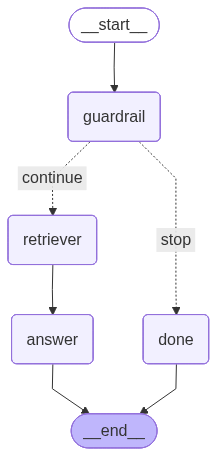

In [322]:
agent

In [323]:
result = agent.invoke({
    "query": "Who is the current CEO of Adobe's main competitor, Canva? "
})

print(result["answer"])

Unused or unrecognized kwargs: text, padding, truncation.


Unfortunately, I cannot find any information about Canva or its CEO in the provided context. The text only contains Adobe's reports and statements, but does not mention Canva or its leadership. Therefore, I must respond with the following:

"I'm sorry, I cannot find that information in the current Adobe reports."


In [324]:
print(result)

{'query': "Who is the current CEO of Adobe's main competitor, Canva? ", 'docs': [{'page': 0, 'type': 'text', 'text': 'explosive growth of generative AI and digital content. As \ncustomer needs have evolved amidst the proliferation of \ndigital surfaces, media types and channels, we are continuing \nto focus on supporting creative professionals across core \ncreative categories like imaging, design, illustration and \nvideo with superior power and precision. We are enabling \nmarketers to streamline creativity and marketing for \ngreater impact, by bringing content and performance data \ntogether and enabling personalization to the individual \ncustomer, in real time at unprecedented scale. For business \nprofessionals and consumers, we are amplifying creativity', 'path': 'extracted_data/text/adbe-2025-stockholder-letter.pdf_text_0_4.txt'}, {'page': 0, 'type': 'text', 'text': 'spanning the entire customer funnel from acquisition to \nmonetization to retention, delivered revenue of $5.37

In [327]:
def run_all_agent(question):
    initial_state = AgentState(
        query=question
    )

    print("QUESTION--  ",initial_state["query"])

    print("\nResponse --- \n\n ")

    final_state = agent.invoke(initial_state)

    print(f"--- FINAL ANSWER ---\n\n{final_state['answer']}\n")
    # print(f"--- ATTEMPTS: {final_state['attempts']} ---\n")
    print(f"--- CONTEXT DOC: {[doc["text"] for doc in final_state["docs"]]} ---\n\n")
    # print(f"--- Reranked CONTEXT DOC: {final_state['rerank_retrieved_docs']} ---\n")
    # print(f"--- Reflection: {final_state['reflection']} ---")

In [328]:
## questions list

query_list = [
    "Based on the R&D spend and product roadmap, which product is Adobe prioritizing for 2025?",
    "Based on the 'Digital Media ARR' chart, what was the ending ARR for 2024?",
    "Which departments of adobe are underperforming in 2024 as per annual report?",
    "What was Adobe's total revenue for Fiscal Year 2024?",
    "How did Adobe's revenue in Q4 2024 compare to Q4 2023?",
    "What does the report cite as Adobe's primary competitive advantage in the AI era?",
    "According to the Acrobat AI Assistant slide, what percentage increase in productivity was noted?",
    "Which business segment—Digital Media or Digital Experience—showed higher year-over-year growth?",
]

for query in query_list:
    run_all_agent(query)

QUESTION--   Based on the R&D spend and product roadmap, which product is Adobe prioritizing for 2025?

Response --- 

 


Unused or unrecognized kwargs: text, padding, truncation.


--- FINAL ANSWER ---

Based on the R&D spend and product roadmap, the answer is not explicitly stated in the provided context. However, we can make some inferences from the information given.

The text mentions that Adobe is focused on supporting creative professionals across core creative categories like imaging, design, illustration, and video. It also highlights the growth of generative AI and digital content, and Adobe's commitment to using AI in a responsible manner.

Given this information, it is likely that Adobe is prioritizing its Creative Cloud applications, which include products like Photoshop, Illustrator, and Premiere Pro. These applications are core to Adobe's creative categories and are likely to be a focus of R&D spend.

However, without more specific information, this is purely an inference, and I would not be confident in stating it as a definitive answer.

Therefore, my final answer would be:

"I'm sorry, I cannot find that information in the current Adobe reports. 

Unused or unrecognized kwargs: text, padding, truncation.
Unused or unrecognized kwargs: text, padding, truncation.


--- FINAL ANSWER ---

Based on the provided context, I cannot find information about the 'Digital Media ARR' chart. However, I can find information about the revenue for 2024 from the text. 

In fiscal year 2024, Adobe delivered record revenue of $21.51 billion across their two businesses, Digital Media and Digital Experience, representing 11% year-over-year growth.

--- CONTEXT DOC: ['explosive growth of generative AI and digital content. As \ncustomer needs have evolved amidst the proliferation of \ndigital surfaces, media types and channels, we are continuing \nto focus on supporting creative professionals across core \ncreative categories like imaging, design, illustration and \nvideo with superior power and precision. We are enabling \nmarketers to streamline creativity and marketing for \ngreater impact, by bringing content and performance data \ntogether and enabling personalization to the individual \ncustomer, in real time at unprecedented scale. For business \nprofessionals a

Unused or unrecognized kwargs: text, padding, truncation.


--- FINAL ANSWER ---

Based on the provided annual report, there is no mention of specific underperforming departments within Adobe in 2024. However, it does mention the revenue growth for the two businesses: 

* Digital Media: $15.86 billion, growing 12% year-over-year
* Digital Experience: $5.37 billion, making it one of the mission-critical providers of marketing technology in the world

The only information provided about growth rates is that the overall revenue across both Digital Media and Digital Experience businesses grew 11% year-over-year in 2024.

--- CONTEXT DOC: ['explosive growth of generative AI and digital content. As \ncustomer needs have evolved amidst the proliferation of \ndigital surfaces, media types and channels, we are continuing \nto focus on supporting creative professionals across core \ncreative categories like imaging, design, illustration and \nvideo with superior power and precision. We are enabling \nmarketers to streamline creativity and marketing for \

Unused or unrecognized kwargs: text, padding, truncation.


--- FINAL ANSWER ---

Based on the provided context, Adobe's total revenue for Fiscal Year 2024 was $21.51 billion.

--- CONTEXT DOC: ['explosive growth of generative AI and digital content. As \ncustomer needs have evolved amidst the proliferation of \ndigital surfaces, media types and channels, we are continuing \nto focus on supporting creative professionals across core \ncreative categories like imaging, design, illustration and \nvideo with superior power and precision. We are enabling \nmarketers to streamline creativity and marketing for \ngreater impact, by bringing content and performance data \ntogether and enabling personalization to the individual \ncustomer, in real time at unprecedented scale. For business \nprofessionals and consumers, we are amplifying creativity', 'spanning the entire customer funnel from acquisition to \nmonetization to retention, delivered revenue of $5.37 billion, \nmaking us one of the mission-critical providers of marketing \ntechnology in the wor

Unused or unrecognized kwargs: text, padding, truncation.


--- FINAL ANSWER ---

According to the provided report, Adobe's primary competitive advantage in the AI era is its ability to uniquely position itself to build on its decade of artificial intelligence (AI) innovation and capitalize on the explosive growth of generative AI and digital content. This is stated in the section titled "DIFFERENTIATED VISION AND STRATEGY". 

Additionally, Adobe emphasizes its focus on supporting creative professionals across core creative categories like imaging, design, illustration, and video with superior power and precision, as well as its ability to enable marketers to streamline creativity and marketing for greater impact by bringing content and performance data together and enabling personalization to the individual customer, in real-time at unprecedented scale.

--- CONTEXT DOC: ['explosive growth of generative AI and digital content. As \ncustomer needs have evolved amidst the proliferation of \ndigital surfaces, media types and channels, we are cont

Unused or unrecognized kwargs: text, padding, truncation.


--- FINAL ANSWER ---

I'm sorry, I cannot find that information in the current Adobe reports.

--- CONTEXT DOC: ['explosive growth of generative AI and digital content. As \ncustomer needs have evolved amidst the proliferation of \ndigital surfaces, media types and channels, we are continuing \nto focus on supporting creative professionals across core \ncreative categories like imaging, design, illustration and \nvideo with superior power and precision. We are enabling \nmarketers to streamline creativity and marketing for \ngreater impact, by bringing content and performance data \ntogether and enabling personalization to the individual \ncustomer, in real time at unprecedented scale. For business \nprofessionals and consumers, we are amplifying creativity', 'spanning the entire customer funnel from acquisition to \nmonetization to retention, delivered revenue of $5.37 billion, \nmaking us one of the mission-critical providers of marketing \ntechnology in the world. We exited the year

Unused or unrecognized kwargs: text, padding, truncation.


--- FINAL ANSWER ---

Based on the provided context, the Digital Media business segment showed higher year-over-year growth. 

* Digital Media business: 
  - Revenue: $15.86 billion (12% year-over-year growth)
  - Page not specified.

* Digital Experience business: 
  - Revenue: $5.37 billion (no year-over-year growth percentage specified)

Therefore, the Digital Media business segment had higher year-over-year growth at 12% compared to the Digital Experience business.

--- CONTEXT DOC: ['explosive growth of generative AI and digital content. As \ncustomer needs have evolved amidst the proliferation of \ndigital surfaces, media types and channels, we are continuing \nto focus on supporting creative professionals across core \ncreative categories like imaging, design, illustration and \nvideo with superior power and precision. We are enabling \nmarketers to streamline creativity and marketing for \ngreater impact, by bringing content and performance data \ntogether and enabling personal